<a href="https://colab.research.google.com/github/Harshavardhanrajuthonti/NLP/blob/main/Assignment_10" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install torch torchvision matplotlib


In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 22.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 618kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 5.62MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.63MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 400),
            nn.ReLU(),
            nn.Linear(400, 40)
        )
        self.fc_mu = nn.Linear(40, latent_dim)
        self.fc_logvar = nn.Linear(40, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [7]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 400),
            nn.ReLU(),
            nn.Linear(400, 40)
        )
        self.fc_mu = nn.Linear(40, latent_dim)
        self.fc_logvar = nn.Linear(40, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [8]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training Loop
epochs = 10
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch, (data, _) in enumerate(train_loader):
        data = data.to(torch.float32)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')


Epoch 1, Loss: 181.57196098632812
Epoch 2, Loss: 163.7823961751302
Epoch 3, Loss: 159.56557192382812
Epoch 4, Loss: 157.30084261067708
Epoch 5, Loss: 155.64720375976563
Epoch 6, Loss: 154.46174943847657
Epoch 7, Loss: 153.41553258463543
Epoch 8, Loss: 152.6102138753255
Epoch 9, Loss: 151.88489994303384
Epoch 10, Loss: 151.24116998697917


In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

generator = Generator()
discriminator = Discriminator()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()


In [11]:
for epoch in range(epochs):
    for batch, (real_images, _) in enumerate(train_loader):
        # Train Discriminator
        real_images = real_images.to(torch.float32)
        real_labels = torch.ones(real_images.size(0), 1)
        fake_labels = torch.zeros(real_images.size(0), 1)

        # Real images
        d_optimizer.zero_grad()
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        # Fake images
        z = torch.randn(real_images.size(0), 100)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()

    print(f'Epoch [{epoch + 1}/{epochs}], D Loss: {d_loss_real + d_loss_fake:.4f}, G Loss: {g_loss:.4f}')


Epoch [1/10], D Loss: 2.2692, G Loss: 0.2306
Epoch [2/10], D Loss: 1.0895, G Loss: 0.8026
Epoch [3/10], D Loss: 1.2266, G Loss: 1.1379
Epoch [4/10], D Loss: 0.8552, G Loss: 1.3355
Epoch [5/10], D Loss: 0.9116, G Loss: 1.1318
Epoch [6/10], D Loss: 0.7697, G Loss: 1.2203
Epoch [7/10], D Loss: 0.6321, G Loss: 1.9773
Epoch [8/10], D Loss: 1.4781, G Loss: 1.4998
Epoch [9/10], D Loss: 1.8239, G Loss: 1.1807
Epoch [10/10], D Loss: 0.9794, G Loss: 1.0547


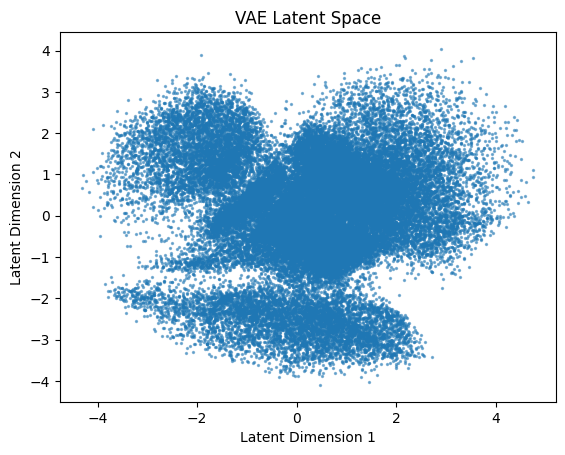

In [10]:
import numpy as np

vae.eval()
z_means = []
with torch.no_grad():
    for batch, (data, _) in enumerate(train_loader):
        data = data.to(torch.float32)
        mu, _ = vae.encode(data)
        z_means.append(mu)

z_means = torch.cat(z_means).numpy()
plt.scatter(z_means[:, 0], z_means[:, 1], s=2, alpha=0.5)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("VAE Latent Space")
plt.show()
